<a id="top"></a>
# Sections

[Intro](#intro)  
[Setup](#setup)  
[Load Data](#loaddata)  
 - [Load Sales History](#saleshistory)  
 - [Load Summary Table](#summarytable)  
 - [Merge](#merge)
 
[Exploration](#explore)  
[Export](#export)  
[Feature Engineering](#features)  
[Modeling](#model)


<a id='intro'></a>
# Intro
[Back to top](#top)

The objective is to forecast short-term (up to 7 days out) price behaviour for all of the sneakers in my dataset.  
In this notebook I'll load & clean the data, and run a regression model to make predictions.  
The results of this analysis will be written to a csv file for use in a flask app.

<a id='setup'></a>
# Setup
[Back to top](#top)

In [1]:
# Imports and options
import pandas as pd
import numpy as np
import matplotlib as plt
import pickle
import re
from random import randint
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from seaborn import plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

% matplotlib inline

# Pandas display options
pd.options.display.max_columns = 40
pd.options.display.max_rows = 200
pd.options.display.float_format = '{:20,.2f}'.format

Define functions for graphs:

In [2]:
def make_hist(df, column, title=None, xlabel='', pct=False, range=None):
    multiplier = 1
    if pct == True:
        multiplier = 100
    fig = plt.figure(figsize=(10,4))
    plt.hist(df[column]*multiplier, bins=50, range=range)
    plt.ylabel('Count')
    plt.xlabel(xlabel if xlabel else '')
    plt.title(column if not title else title)

In [3]:
def make_box(df, xcolumn, title=None, ylabel='', xlabel='', pct=False):
    multiplier = 1
    if pct == True:
        multiplier = 100
    fig = plt.figure(figsize=(10,4))
    ax = sns.boxplot(x=df[xcolumn]*multiplier, showfliers=False, palette="deep")
    ax.set(title=xcolumn if not title else title)
    ax.set(xlabel=xcolumn if not xlabel else xlabel )
    return ax

In [4]:
def make_line(df, xcolumn, ycolumn, title=None, ylabel='', xlabel='Date', pct=False):
    multiplier = 1
    if pct == True:
        multiplier = 100
    fig = plt.figure(figsize=(10,4))
    plt.plot(df[xcolumn], df[ycolumn]*multiplier, linewidth=1)
    plt.title(xcolumn if not title else title)
    plt.ylabel(ylabel if ylabel else '')
    plt.xlabel(xlabel)
    plt.xticks(rotation=45)
    return plt

In [5]:
def make_bar(df, xcolumn, ycolumn, title=None, xlabel='', ylabel='', pct=False):
    fig = plt.figure(figsize=(10,4))
    if pct == True:
        df[ycolumn] = df[ycolumn] * 100
    ax = df.groupby(xcolumn)[ycolumn].mean().plot(kind = 'bar')
    plt.xlabel(xlabel if xlabel else '')
    plt.ylabel(ylabel if ylabel else '')
    plt.title(xcolumn if not title else title)

Define general helper functions:

In [6]:
def drop_columns(df, columns):
    '''Drops a list of columns in a dataframe'''
    for c in columns:
        df.drop(c, axis = 1, inplace = True)
        
def get_percent(part, whole):
    return round(100 * float(part)/float(whole), 2)

def unique_list(l):
    '''makes a unique list'''
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

<a id='loaddata'></a>
# Load Data
[Back to top](#top)

### File Descriptions:
***sales_history.pkl*** - history by shoe by sale   
***shoe_file.json*** - descriptive information by shoe


<a id='saleshistory'></a>
## Load Sales History
[Back to top](#top)

In [7]:
# Open the cleaned sales_history data
with open('data/sales_history.pkl', 'rb') as picklefile:
    sales_history = pickle.load(picklefile)
    
original_sales_length = len(sales_history)
print original_sales_length

203001


In [8]:
sales_history.head(2)

,name,weekday,date_time,shoe_size,sale_price
real_date,,,,,
2017-03-11 15:07:00,Jordan 9 Retro OG (2016),Saturday,"March 11, 2017 3:07 PM",11,300
2017-03-11 13:26:00,Jordan 9 Retro OG (2016),Saturday,"March 11, 2017 1:26 PM",9,300


In [9]:
# Cleanup functions
def extract_date_part(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['sale_date'] = df.index.date
    
def price_to_float(df, cols):
    '''strips out non-numericals and convert to floats'''
    for c in cols:
        df[c] = df[c].replace({'\D': ''}, regex=True)
        df[c] = pd.to_numeric(df[c], errors='coerce')
        
def shoe_brand(x):
    """get brand of shoe based on line"""
    if x in adidas_list:
        x = "adidas"
    elif x in nike_list:
        x = "nike"
    return x

def clean_sizes(x):
    """convert shoe sizes into floats"""
    if "K" in x:
        x = 1
    elif "Y" in x:
        x = 1
    else:
        x = re.sub(r'[a-zA-Z-/]', ' ', x)
        x_list = [float(x) for x in x.strip().split()]
        x = sum(x_list) / float(len(x_list))
        x = round(x, 2)
    return x

def core_fringe(x):
    """converts shoe size into 1 for fringe or 0 for core sizing"""
    if x < 7.5:
        x = 1
    elif x > 14:
        x = 1
    else:
        x = 0
    return x


In [10]:
# Maintain lists of lines within shoe brands
adidas_list = ['y-3', 'y3', 'adidas','yeezy', 'nmd']
nike_list = ['jordan','nike','foamposite','air','kobe','lebron','kd','sf','kyrie','lunar','cavs',
                 'pg','lebron','flyknit']
other_list = ['reebok', 'new', 'asics','vans','ua','puma','saucony','diadora','timberland']

In [11]:
# Create a duplicate column for datetime and shoe name
sales_history['sale_date_time'] = sales_history.index
sales_history['shoe_name'] = sales_history['name']

In [12]:
# Clean up the sales_history dataframe 
extract_date_part(sales_history)
price_to_float(sales_history, ['sale_price'])
drop_columns(sales_history, ['date_time'])

# Extract the line from the shoe name and add the brand column
sales_history['line'] = sales_history['name'].str.split().str.get(0).str.lower()
sales_history['brand'] = sales_history['line'].apply(lambda x: shoe_brand(x))

# Add a column for shoe size range
sales_history['size_number'] = sales_history['shoe_size'].apply(lambda x: clean_sizes(x))
sales_history['shoe_size'] = sales_history['size_number'].apply(lambda x: core_fringe(x))

In [13]:
sales_history.head(2)

,name,weekday,shoe_size,sale_price,sale_date_time,shoe_name,year,month,day,hour,sale_date,line,brand,size_number
real_date,,,,,,,,,,,,,,
2017-03-11 15:07:00,Jordan 9 Retro OG (2016),Saturday,0,300,2017-03-11 15:07:00,Jordan 9 Retro OG (2016),2017,3,11,15,2017-03-11,jordan,nike,11.00
2017-03-11 13:26:00,Jordan 9 Retro OG (2016),Saturday,0,300,2017-03-11 13:26:00,Jordan 9 Retro OG (2016),2017,3,11,13,2017-03-11,jordan,nike,9.00


<a id='summarytable'></a>
## Load Summary Table
[Back to top](#top)

In [14]:
summary = pd.read_json('data/shoe_file.json')

In [15]:
orig_summary_length = len(summary)
print orig_summary_length

995


In [16]:
summary.head(2)

,colorway,highest_bid,image_url,lowest_ask,name,num_asks,num_bids,num_sales,original retail,release date,style
0,black/dark concord-white,$285,https://stockx.imgix.net/Air-Jordan-11-Retro-S...,$270,Jordan 11 Retro\nSpace Jam (2016),280,81,# OF SALES: 360,$220,12.10.16,378037-003
1,black/varsity red-varsity royal,$273,https://stockx.imgix.net/Air-Jordan-1-Retro-To...,$200,Jordan 1 Retro\nTop 3,101,115,# OF SALES: 40,$160,11.28.16,555088-026


In [17]:
# Cleanup functions for the summary table
def consolidate_colors(x):
    '''Simplifies shoe colors into basic colors(black, white, etc) or other'''
    things_to_replace = ["/","-","core","true","pirate","fierce","turtledove","varsity",
                         "fire","royal","gym","wolf","infared","23","metallic","bone",
                         "dark","university","concord","anthracite","coin","cool","cement","   "]
    for thing in things_to_replace:
        x = x.replace(thing," ")
        x = x.strip()
        
    x = ' '.join(sorted(unique_list(x.split())))
    
    if x == "black white":
        x = "basic"
    elif x == "black":
        x = "basic"
    elif x == "white":
        x = "basic"
    else:
        x = "other"
    
    return x

In [18]:
# Rename columns
summary.rename(
    columns={'release date':'release_date', 'original retail':'original_retail','style':'style_code'}, inplace=True)

In [19]:
# Replace string values in price columns
price_to_float(summary,['num_sales', 'highest_bid', 'lowest_ask', 'original_retail'])

# Convert release date to datetime format    
summary = summary[~summary.release_date.str.contains("n/a")]
summary['release_date'] = pd.to_datetime(summary['release_date'],  format=' %m.%d.%y')

# Remove newline from the name column
summary['name'] = summary.name.str.replace("\n", " ")

# Add a simplified color column for use in later modeling
summary['main_color'] = summary['colorway'].apply(lambda x: consolidate_colors(x))

# Drop any duplicates across the whole dataframe
summary = summary.drop_duplicates()

In [20]:
# Pickle list for use in the instagram scraper
unique_names = [name.encode('ascii','ignore') for name in summary.name.unique()]
unique_names = sorted(unique_names)

with open('data/shoe_name_list.pkl', 'wb') as picklefile:
    pickle.dump(unique_names, picklefile)

In [21]:
sales_history.head(2)

,name,weekday,shoe_size,sale_price,sale_date_time,shoe_name,year,month,day,hour,sale_date,line,brand,size_number
real_date,,,,,,,,,,,,,,
2017-03-11 15:07:00,Jordan 9 Retro OG (2016),Saturday,0,300,2017-03-11 15:07:00,Jordan 9 Retro OG (2016),2017,3,11,15,2017-03-11,jordan,nike,11.00
2017-03-11 13:26:00,Jordan 9 Retro OG (2016),Saturday,0,300,2017-03-11 13:26:00,Jordan 9 Retro OG (2016),2017,3,11,13,2017-03-11,jordan,nike,9.00


<a id='merge'></a>
## Merge
[Back to top](#top)

In [22]:
# Merge the summary and sales_history dataframes
sales_history = sales_history.merge(summary, on='name', sort=False, how='inner')

# Sort the new merged table by shoe name
sales_history.sort_values(['name'], inplace=True)

In [23]:
sales_history.head(2)

,name,weekday,shoe_size,sale_price,sale_date_time,shoe_name,year,month,day,hour,sale_date,line,brand,size_number,colorway,highest_bid,image_url,lowest_ask,num_asks,num_bids,num_sales,original_retail,release_date,style_code,main_color
90233,Adidas AW Run Alexander Wang Black,Wednesday,0,325,2017-03-15 16:05:00,Adidas AW Run Alexander Wang Black,2017,3,15,16,2017-03-15,adidas,adidas,9.00,black/white,380.00,https://stockx.imgix.net/Adidas-AW-Run-Alexand...,280.00,99,30,29,230.00,2017-03-04,cm7825,basic
90243,Adidas AW Run Alexander Wang Black,Monday,0,350,2017-03-13 11:41:00,Adidas AW Run Alexander Wang Black,2017,3,13,11,2017-03-13,adidas,adidas,12.00,black/white,380.00,https://stockx.imgix.net/Adidas-AW-Run-Alexand...,280.00,99,30,29,230.00,2017-03-04,cm7825,basic


In [24]:
# Drop unnecessary columns:
drop_list = ['lowest_ask','num_asks','num_bids','num_sales','highest_bid']

drop_columns(sales_history, drop_list)

In [25]:
sales_history.head()

,name,weekday,shoe_size,sale_price,sale_date_time,shoe_name,year,month,day,hour,sale_date,line,brand,size_number,colorway,image_url,original_retail,release_date,style_code,main_color
90233,Adidas AW Run Alexander Wang Black,Wednesday,0,325,2017-03-15 16:05:00,Adidas AW Run Alexander Wang Black,2017,3,15,16,2017-03-15,adidas,adidas,9.00,black/white,https://stockx.imgix.net/Adidas-AW-Run-Alexand...,230.00,2017-03-04,cm7825,basic
90243,Adidas AW Run Alexander Wang Black,Monday,0,350,2017-03-13 11:41:00,Adidas AW Run Alexander Wang Black,2017,3,13,11,2017-03-13,adidas,adidas,12.00,black/white,https://stockx.imgix.net/Adidas-AW-Run-Alexand...,230.00,2017-03-04,cm7825,basic
90244,Adidas AW Run Alexander Wang Black,Monday,0,315,2017-03-13 11:12:00,Adidas AW Run Alexander Wang Black,2017,3,13,11,2017-03-13,adidas,adidas,12.50,black/white,https://stockx.imgix.net/Adidas-AW-Run-Alexand...,230.00,2017-03-04,cm7825,basic
90245,Adidas AW Run Alexander Wang Black,Monday,0,325,2017-03-13 10:41:00,Adidas AW Run Alexander Wang Black,2017,3,13,10,2017-03-13,adidas,adidas,9.50,black/white,https://stockx.imgix.net/Adidas-AW-Run-Alexand...,230.00,2017-03-04,cm7825,basic
90246,Adidas AW Run Alexander Wang Black,Monday,0,275,2017-03-13 09:14:00,Adidas AW Run Alexander Wang Black,2017,3,13,9,2017-03-13,adidas,adidas,11.00,black/white,https://stockx.imgix.net/Adidas-AW-Run-Alexand...,230.00,2017-03-04,cm7825,basic


<a id='explore'></a>
# Exploration
[Back to top](#top)

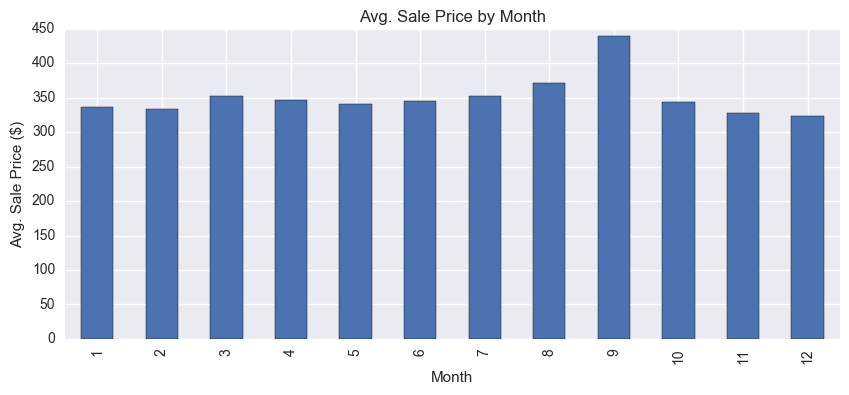

In [27]:
make_bar(sales_history, 'month', 'sale_price', title="Avg. Sale Price by Month", 
         xlabel="Month", ylabel="Avg. Sale Price ($)")

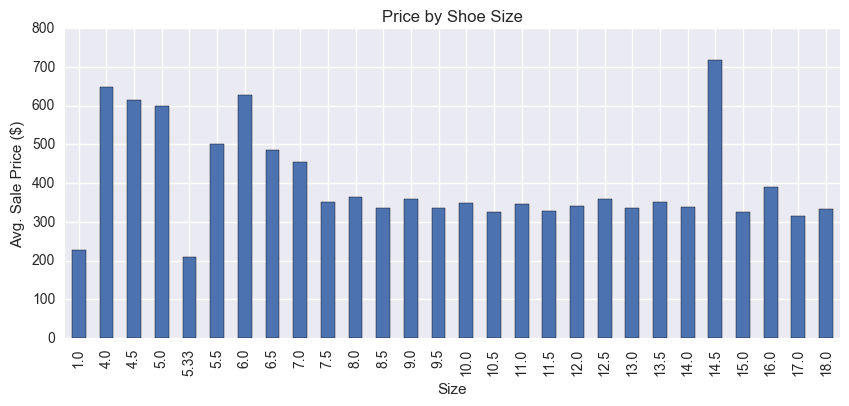

In [28]:
make_bar(sales_history, 'size_number', 'sale_price', title="Price by Shoe Size", xlabel="Size", 
         ylabel="Avg. Sale Price ($)")

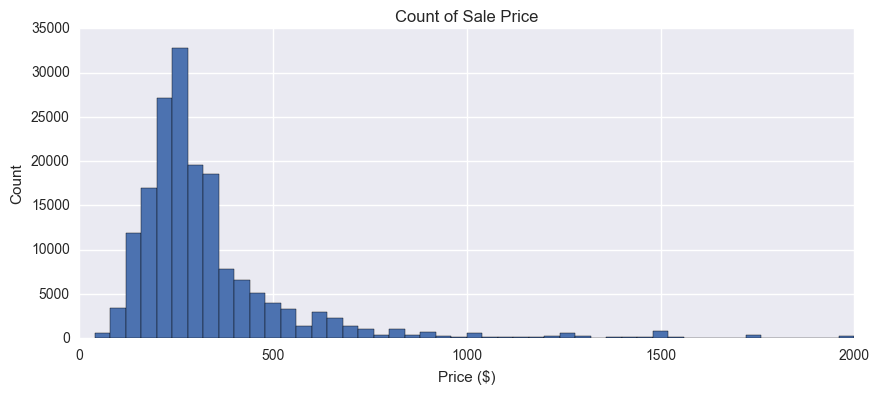

In [29]:
make_hist(sales_history, 'sale_price', range=[0,2000], title='Count of Sale Price', xlabel="Price ($)")

<a id='export'></a>
# Export
[Back to top](#top)

Created a few tables below for the web app to pull from.

In [100]:
with open('data/final_sales_history.pkl', 'wb') as picklefile:
    pickle.dump(sales_history, picklefile)

<a id='features'></a>
# Feature Engineering
[Back to top](#top)

In [101]:
## Add a num_sales (frequency) column
sales_history['num_sales'] = sales_history.groupby('shoe_name')['shoe_name'].transform('count')

In [102]:
## Limit everything below this to shoes with over 50 sales recorded
print(len(sales_history))
sales_history = sales_history[sales_history.num_sales > 50]
print(len(sales_history))

175844
171396


In [103]:
# Aggregate to sales by day
shoes = sales_history[['name', 'sale_date', 'sale_price']].groupby(['name', 'sale_date'])
shoes = shoes.aggregate(['mean', 'count']).reset_index()

# Collapse the header
shoes.columns = shoes.columns.droplevel(0)

# Convert groupby object to dataframe & name columns
shoes = pd.DataFrame(shoes)
shoes.columns = ['name', 'sale_date', 'sale_price', 'volume']
sales_history = sales_history.reset_index()

# add back in the other information about the shoe
more_info = (sales_history[['name', 'main_color', 'line', 'brand', 'style_code', 'image_url',
                           'release_date', 'original_retail', 'colorway']]
             .drop_duplicates())

shoes = shoes.merge(more_info, on = 'name')

In [104]:
# Take the log of the sale price
shoes['log_sale_price'] = np.log(shoes.sale_price)

In [105]:
shoes.sample(5)

,name,sale_date,sale_price,volume,main_color,line,brand,style_code,image_url,release_date,original_retail,colorway,log_sale_price
1861,Adidas NMD Pharrell HU Human Race Scarlet,2016-10-01,768.67,3,other,adidas,adidas,bb0616,https://stockx.imgix.net/Adidas-NMD-HU-Pharrel...,2016-09-29,240.00,scarlet/scarlet/white,6.64
16198,Foamposite One Chromeposite,2015-10-12,725.00,1,other,foamposite,nike,744306-001,https://stockx.imgix.net/Air-Foamposite-One-Ch...,2015-02-15,275.00,metallic silver/metallic silver-black,6.59
54827,Jordan 5 Retro Olympic (2016),2017-03-12,150.00,1,other,jordan,nike,136027-133,https://stockx.imgix.net/Air-Jordan-5-Retro-Ol...,2016-08-20,190.00,white/black-metallic gold coin,5.01
19188,Foamposite One Wu-Tang Optic Yellow,2016-08-01,275.00,4,other,foamposite,nike,314996-701,https://stockx.imgix.net/Air-Foamposite-One-Op...,2016-06-24,230.00,optic yellow/optic yellow-black,5.62
12689,Air Huarache Undefeated LA,2016-09-08,184.50,2,other,air,nike,853940-114,https://stockx.imgix.net/Nike-Air-Huarache-Und...,2016-07-16,120.00,white/white-hyper cobalt,5.22


# Time Features

In [108]:
## Overwrite sales_history - no more original sales_history dataframe anymore
sales_history = shoes.copy()
sales_history['shoe_name'] = sales_history['name']
sales_history['sale_date'] = pd.to_datetime(sales_history['sale_date'])
sales_history['time_since_release'] = sales_history['sale_date'] - sales_history['release_date']

# change the time delta into a count of days since release date
sales_history['total_days_td'] = sales_history['time_since_release'].dt.total_seconds() / (24 * 60 * 60)

In [109]:
# Last sale price
sales_history['sale_lagged_1'] = sales_history.groupby(['shoe_name']).sale_price.shift(1)
sales_history['pct_vs_last'] = sales_history['sale_price'] / sales_history['sale_lagged_1'] - 1
# Sale price minus 2
sales_history['sale_lagged_2'] = sales_history.groupby(['shoe_name']).sale_price.shift(2)
sales_history['pct_vs_last_2'] = sales_history['sale_lagged_1'] / sales_history['sale_lagged_2'] - 1
# Sale price minus 3
sales_history['sale_lagged_3'] = sales_history.groupby(['shoe_name']).sale_price.shift(3)
sales_history['pct_vs_last_3'] = sales_history['sale_lagged_2'] / sales_history['sale_lagged_3'] - 1
# Sale price minus 4
sales_history['sale_lagged_4'] = sales_history.groupby(['shoe_name']).sale_price.shift(4)
sales_history['pct_vs_last_4'] = sales_history['sale_lagged_3'] / sales_history['sale_lagged_4'] - 1

### Note: computing rolling average requires unique index of name + datetime

In [110]:
sales_history = sales_history.set_index(['name', 'sale_date'])

In [111]:
# Rolling average
sales_history['rolling_avg_4'] = sales_history.groupby(level = 0)['sale_price'].rolling(4).mean().shift(1).reset_index(0,drop=True)
# sales_history['rolling_avg_20'] = sales_history.groupby(level = 0)['sale_price'].rolling(20).mean().shift(1).reset_index(0,drop=True)

# Insert an intercept
sales_history['intercept'] = 1

In [112]:
# Check that the lagged sales are calculated properly
sales_history.head(100)

sale_price  \
name                                           sale_date                         
Adidas AW Run Alexander Wang Black             2017-03-03               586.00   
                                               2017-03-05               517.00   
                                               2017-03-06               422.67   
                                               2017-03-08               370.67   
                                               2017-03-09               343.83   
                                               2017-03-10               344.12   
                                               2017-03-11               358.43   
                                               2017-03-12               346.50   
                                               2017-03-13               333.57   
                                               2017-03-14               322.67   
                                               2017-03-15               321.00   
Adidas AW Run Clean Alexander Wang White       2017-03-03               573.00   
                                               2017-03-04               535.50   
                                               2017-03-05               573.00   
                                               2017-03-07               442.43   
                                               2017-03-08               420.50   
                                               2017-03-09               331.42   
                                               2017-03-10               327.09   
                                               2017-03-11               395.00   
                                               2017-03-12               332.88   
                                               2017-03-13               355.42   
                                               2017-03-14               284.00   
                                               2017-03-15               292.86   
Adidas EQT Guidance '93 Pusha T "Black Market" 2015-11-26               395.00   
                                               2015-11-27               345.36   
                                               2015-11-28               319.93   
                                               2015-11-29               339.00   
                                               2015-11-30               325.00   
                                               2015-12-01               323.67   
                                               2015-12-02               313.71   
                                               2015-12-03               310.00   
                                               2015-12-04               337.50   
                                               2015-12-05               283.00   
                                               2015-12-06               303.86   
                                               2015-12-08               325.00   
                                               2015-12-09               283.00   
                                               2015-12-10               297.00   
                                               2015-12-11               302.00   
                                               2015-12-12               325.00   
                                               2015-12-13               353.00   
                                               2015-12-14               400.00   
                                               2015-12-15               292.67   
                                               2015-12-16               291.00   
                                               2015-12-18               307.14   
                                               2015-12-19               270.00   
                                               2015-12-21               284.00   
                                               2015-12-22               322.33   
                                               201

In [113]:
# Then drop the NaNs.
sales_history = sales_history.dropna()

In [114]:
# Transform the other variables into logs
sales_history['sale_lagged_1'] = np.log(sales_history.sale_lagged_1)
sales_history['sale_lagged_2'] = np.log(sales_history.sale_lagged_2)
sales_history['sale_lagged_3'] = np.log(sales_history.sale_lagged_3)

In [115]:
sales_history.head(2)

sale_price  volume  \
name                               sale_date                                 
Adidas AW Run Alexander Wang Black 2017-03-09               343.83      12   
                                   2017-03-10               344.12       8   

                                              main_color    line   brand  \
name                               sale_date                               
Adidas AW Run Alexander Wang Black 2017-03-09      basic  adidas  adidas   
                                   2017-03-10      basic  adidas  adidas   

                                              style_code  \
name                               sale_date               
Adidas AW Run Alexander Wang Black 2017-03-09     cm7825   
                                   2017-03-10     cm7825   

                                                                                       image_url  \
name                               sale_date                                                       
Adidas AW Run Alexander Wang Black 2017-03-09  https://stockx.imgix.net/Adidas-AW-Run-Alexand...   
                                   2017-03-10  https://stockx.imgix.net/Adidas-AW-Run-Alexand...   

                                              release_date  \
name                               sale_date                 
Adidas AW Run Alexander Wang Black 2017-03-09   2017-03-04   
                                   2017-03-10   2017-03-04   

                                                   original_retail  \
name                               sale_date                         
Adidas AW Run Alexander Wang Black 2017-03-09               230.00   
                                   2017-03-10               230.00   

                                                   colorway  \
name                               sale_date                  
Adidas AW Run Alexander Wang Black 2017-03-09   black/white   
                                   2017-03-10   black/white   

                                                    log_sale_price  \
name                               sale_date                         
Adidas AW Run Alexander Wang Black 2017-03-09                 5.84   
                                   2017-03-10                 5.84   

                                                                        shoe_name  \
name                               sale_date                                        
Adidas AW Run Alexander Wang Black 2017-03-09  Adidas AW Run Alexander Wang Black   
                                   2017-03-10  Adidas AW Run Alexander Wang Black   

                                               time_since_release  \
name                               sale_date                        
Adidas AW Run Alexander Wang Black 2017-03-09              5 days   
                                   2017-03-10              6 days   

                                                     total_days_td  \
name                               sale_date                         
Adidas AW Run Alexander Wang Black 2017-03-09                 5.00   
                                   2017-03-10                 6.00   

                                                     sale_lagged_1  \
name                               sale_date                         
Adidas AW Run Alexander Wang Black 2017-03-09                 5.92   
                                   2017-03-10                 5.84   

                                                       pct_vs_last  \
name                               sale_date                         
Adidas AW Run Alexander Wang Black 2017-03-09                -0.07   
                                   2017-03-10                 0.00   

                                                     sale_lagged_2  \
name                               sale_date                         
Adidas AW Run Alexander Wang Black 2017-03-09                 6.05   
                                   2017-03-10                

In [116]:
column_names = list(sales_history.columns.values)
len(column_names)

24

<a id='model'></a>
# Model for all shoes
[Back to top](#top)

In [117]:
all_shoes = sales_history.reset_index()
all_shoes = all_shoes.dropna()
all_shoes = all_shoes.sort_values(['sale_date'])

In [118]:
# save the min and max of rolling average for the forecast function later
rolling_avg_4_min = all_shoes.rolling_avg_4.min()
rolling_avg_4_max = all_shoes.rolling_avg_4.max()
# rolling_avg_20_min = all_shoes.rolling_avg_20.min()
# rolling_avg_20_max = all_shoes.rolling_avg_20.max()

In [120]:
# Normalize the team_stats dataframe between 0 and 1 (between -1 and 1 would be team_stats.mean()/ same as below)
all_shoes['rolling_avg_4'] = ((all_shoes['rolling_avg_4'] 
                               - all_shoes.rolling_avg_4.min()) 
                               / (all_shoes.rolling_avg_4.max() 
                               - all_shoes.rolling_avg_4.min()))
all_shoes.head(3)

,name,sale_date,sale_price,volume,main_color,line,brand,style_code,image_url,release_date,original_retail,colorway,log_sale_price,shoe_name,time_since_release,total_days_td,sale_lagged_1,pct_vs_last,sale_lagged_2,pct_vs_last_2,sale_lagged_3,pct_vs_last_3,sale_lagged_4,pct_vs_last_4,rolling_avg_4,intercept
63114,Jordan Spiz'ike Bordeaux,2012-05-02,250.00,1,other,jordan,nike,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.52,Jordan Spiz'ike Bordeaux,88 days,88.00,5.52,0.00,5.52,0.00,5.52,0.00,250.00,0.00,0.04,1
63115,Jordan Spiz'ike Bordeaux,2012-05-03,240.00,1,other,jordan,nike,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.48,Jordan Spiz'ike Bordeaux,89 days,89.00,5.52,-0.04,5.52,0.00,5.52,0.00,250.00,0.00,0.04,1
63116,Jordan Spiz'ike Bordeaux,2012-05-06,300.00,1,other,jordan,nike,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.70,Jordan Spiz'ike Bordeaux,92 days,92.00,5.48,0.25,5.52,-0.04,5.52,0.00,250.00,0.00,0.04,1


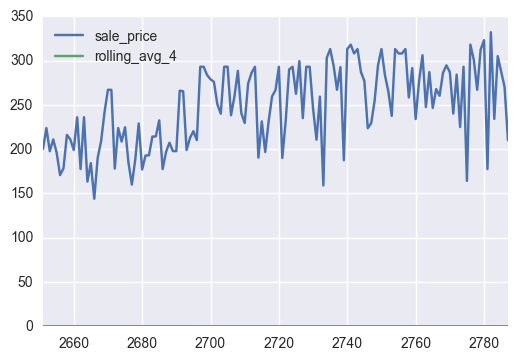

In [121]:
all_shoes.loc[all_shoes.name == 'Adidas NMD R1 Black Red', ['sale_price', 'rolling_avg_4']].plot();

In [122]:
# get the dummy variabls for the non-numerical features
for col in all_shoes[['main_color','brand','line']]:
    dummies = pd.get_dummies(all_shoes[col], prefix = col)
    all_shoes = all_shoes.join(dummies)
    all_shoes = all_shoes.drop(col, 1)

In [123]:
# drop the nas again?
all_shoes = all_shoes.dropna()
all_shoes.head()

,name,sale_date,sale_price,volume,style_code,image_url,release_date,original_retail,colorway,log_sale_price,shoe_name,time_since_release,total_days_td,sale_lagged_1,pct_vs_last,sale_lagged_2,pct_vs_last_2,sale_lagged_3,pct_vs_last_3,sale_lagged_4,...,rolling_avg_4,intercept,main_color_basic,main_color_other,brand_adidas,brand_asics,brand_nike,brand_reebok,line_adidas,line_air,line_asics,line_foamposite,line_jordan,line_kd,line_kobe,line_kyrie,line_lebron,line_nike,line_reebok,line_sf
63114,Jordan Spiz'ike Bordeaux,2012-05-02,250.00,1,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.52,Jordan Spiz'ike Bordeaux,88 days,88.00,5.52,0.00,5.52,0.00,5.52,0.00,250.00,...,0.04,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63115,Jordan Spiz'ike Bordeaux,2012-05-03,240.00,1,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.48,Jordan Spiz'ike Bordeaux,89 days,89.00,5.52,-0.04,5.52,0.00,5.52,0.00,250.00,...,0.04,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63116,Jordan Spiz'ike Bordeaux,2012-05-06,300.00,1,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.70,Jordan Spiz'ike Bordeaux,92 days,92.00,5.48,0.25,5.52,-0.04,5.52,0.00,250.00,...,0.04,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63117,Jordan Spiz'ike Bordeaux,2012-05-07,246.67,3,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.51,Jordan Spiz'ike Bordeaux,93 days,93.00,5.70,-0.18,5.48,0.25,5.52,-0.04,250.00,...,0.04,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63118,Jordan Spiz'ike Bordeaux,2012-05-08,220.00,1,315371-070,https://stockx.imgix.net/Air-Jordan-Spizike-Bo...,2012-02-04,175.00,neutral grey/varsity maize-dark charcoal-sapp...,5.39,Jordan Spiz'ike Bordeaux,94 days,94.00,5.51,-0.11,5.70,-0.18,5.48,0.25,250.00,...,0.04,1,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [124]:
all_shoes = all_shoes.replace([np.inf, -np.inf], np.nan)
all_shoes = all_shoes.dropna()
all_shoes = all_shoes.reset_index()


# Desired outcome variable
y = all_shoes.log_sale_price

# Full set of features - no shoe size anymore
X = all_shoes[['intercept', 'rolling_avg_4','pct_vs_last_2','pct_vs_last_3','total_days_td',
              'main_color_basic', 'original_retail','brand_nike','line_foamposite','line_air']]

In [125]:
X.head()

,intercept,rolling_avg_4,pct_vs_last_2,pct_vs_last_3,total_days_td,main_color_basic,original_retail,brand_nike,line_foamposite,line_air
0,1,0.04,0.00,0.00,88.00,0.00,175.00,1.00,0.00,0.00
1,1,0.04,0.00,0.00,89.00,0.00,175.00,1.00,0.00,0.00
2,1,0.04,-0.04,0.00,92.00,0.00,175.00,1.00,0.00,0.00
3,1,0.04,0.25,-0.04,93.00,0.00,175.00,1.00,0.00,0.00
4,1,0.04,-0.18,0.25,94.00,0.00,175.00,1.00,0.00,0.00


In [126]:
# Set test train split
cutpoint = round((len(X)/4)*3)

X_train = X.ix[:cutpoint,:]
X_test = X.ix[cutpoint:,:]

y_train = y.ix[:cutpoint]
y_test = y.ix[cutpoint:]

model = sm.OLS(y_train, X_train)
est = model.fit()
y_train_pred = est.predict(X_train)
y_test_pred = est.predict(X_test)
r_2 = est.rsquared
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_sale_price   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 1.642e+04
Date:                Mon, 22 May 2017   Prob (F-statistic):               0.00
Time:                        18:01:31   Log-Likelihood:                -7093.3
No. Observations:               55258   AIC:                         1.421e+04
Df Residuals:                   55248   BIC:                         1.430e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
intercept            4.9104      0.005    895.637      0.000         4.900     4.921
rolling_avg_4        5.9130      0.023    262.415      0.000         5.869     5.957
pct_vs_last_2       -0.0162      0.006     -2.577      0.010        -0.029    -0.004
pct_vs_last_3       -0.0176      0.006     -2.794      0.005        -0.030    -0.005
total_days_td        0.0002   2.57e-06     84.780      0.000         0.000     0.000
main_color_basic     0.0104      0.005      2.091      0.037         0.001     0.020
original_retail      0.0019   2.44e-05     79.651      0.000         0.002     0.002
brand_nike          -0.0973      0.004    -22.140      0.000        -0.106    -0.089
line_foamposite      0.0313      0.005      6.936      0.000         0.022     0.040
line_air             0.0474      0.005      9.149      0.000         0.037     0.058
==============================================================================
Omnibus:                    22029.083   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           360020.042
Skew:                          -1.487   Prob(JB):                         0.00
Kurtosis:                      15.146   Cond. No.                     1.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# calculate means of y_test and y_train
mean_y_test = np.mean(y_test)
mean_y_train = np.mean(y_train)

# print r_squared (train and test)
print(1 - (mean_squared_error(y_train, y_train_pred)/mean_squared_error([mean_y_train]*len(y_train), y_train)))
print(1 - (mean_squared_error(y_test, y_test_pred)/mean_squared_error([mean_y_test]*len(y_test), y_test)))

# Tree Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
tree = RandomForestRegressor(n_estimators=1000, max_depth=5)

tree_model = tree.fit(X_train, y_train)

In [ ]:
train_tree_pred = tree_model.predict(X_train)
test_tree_pred = tree_model.predict(X_test)
all_preds = tree_model.predict(X)

In [ ]:
# print r_squared (train and test)
print(1 - (mean_squared_error(y_train, train_tree_pred)/mean_squared_error([mean_y_train]*len(y_train), y_train)))
print(1 - (mean_squared_error(y_test, test_tree_pred)/mean_squared_error([mean_y_test]*len(y_test), y_test)))

In [ ]:
tree_model.feature_importances_

In [ ]:
plt.scatter(y_test, test_tree_pred);

In [ ]:
# import forestci as fci
# http://contrib.scikit-learn.org/forest-confidence-interval/auto_examples/plot_mpg.html#sphx-glr-auto-examples-plot-mpg-py
# calculate inbag and unbiased variance
# inbag = fci.calc_inbag(X_train.shape[0], tree)
# unbiased = fci.random_forest_error(tree, inbag, X_train, X_test)

# Evaluate test set results

In [ ]:
# Get predicted and actual Y values from test data set
# Actual price
y_test2 = y_test.reset_index(drop = True)
print(y_test2.tail(1))
# Predicted price
yhat = pd.Series(test_tree_pred)
print(yhat.tail(1))
# Shoe and date info
names_dates = all_shoes.ix[cutpoint:, ['name', 'date']].reset_index(drop = True)
print(names_dates.tail(1))

In [ ]:
# How well does the model predict if the price will go up or down? 
testing = pd.concat([names_dates, y_test2, yhat], axis = 1)
testing.columns = ['name', 'date', 'y', 'yhat']
testing.y = np.exp(testing.y)
testing.yhat = np.exp(testing.yhat)
testing = testing.set_index(['name', 'date'])
testing = testing.sort_index()
testing = testing.reset_index()
# Lagged y and yhat
testing['y_last'] = testing.groupby(['name']).y.shift(1)
testing['yhat_last'] = testing.groupby(['name']).yhat.shift(1)
# Compare both y and yhat to previous y value
testing['y_change'] = testing.y - testing.y_last
testing['yhat_change'] = testing.yhat - testing.y_last ## less accurate if you use yhat last
# Flags for increase in y 
testing['y_up'] = 0
testing.loc[testing.y_change >= 0, 'y_up'] = 1
testing['yhat_up'] = 0
testing.loc[testing.yhat_change >= 0, 'yhat_up'] = 1
testing = testing.dropna()
# Summary of results
testsum = testing.groupby(['y_up', 'yhat_up']).size()
testsum = pd.DataFrame(testsum).reset_index()
testsum.columns = ['y_up', 'yhat_up', 'n'] 
pct_num = (testsum.loc[0, 'n'] + testsum.loc[3, 'n'])
pct_denom = testsum['n'].sum()
pct_correct = round(float(pct_num) / float(pct_denom), 3)
print(testsum)
print(pct_num)
print(pct_denom)
print(pct_correct)
testing.head(15)

In [ ]:
testing.describe()

# Forecast

In [ ]:
# Predictions for the flask app
# Shoe list for forecast
shoe_list = [i for i in all_shoes['name'].unique()]
shoe_n = len(shoe_list)

# have a random shoe to check whenever i want to check a shoe
chosen_shoe = shoe_list[randint(0, shoe_n)]

# Data set for forecast - all the x variables but also name, sale price, pct vs last
forecast = all_shoes[['name', 'sale_price', 'pct_vs_last', 'intercept', 'rolling_avg_4','pct_vs_last_2','pct_vs_last_3','log_total_days_td',
              'main_color_basic', 'original_retail','brand_nike','line_Foamposite','line_Air']]

# Choose a shoe for one run
x = forecast[forecast.name == chosen_shoe].reset_index(drop = True)
x.tail(1)

In [ ]:
def make_new_row(df, mod):
    """ Forecast the sale price of the next sale using the model """
    # The last row of the dataframe & sale_price
    last_row = (len(df) - 1)
    last_sale_price = df.sale_price[last_row]
    
    # the row that will be created
    new_row_num = len(df)

    # Generate X values for next observation
    rolling_avg_4 = df.sale_price[(last_row - 3):(last_row + 1)].mean() # adjust for rolling window
#     rolling_avg_20 = df.sale_price[(last_row - 19):(last_row + 1)].mean() # adjust for rolling window

    # Normalize rolling average using global variables created above 
    rolling_avg_4 = (rolling_avg_4 - rolling_avg_4_min) / (rolling_avg_4_max - rolling_avg_4_min)
    # rolling_avg_20 = (rolling_avg_20 - rolling_avg_20_min) / (rolling_avg_20_max - rolling_avg_20_min)
    
    # take pct vs last from row above
    pct_vs_last_2 = df.pct_vs_last[last_row]
    pct_vs_last_3 = df.pct_vs_last_2[last_row]
    
    # added 1 day to the time delta and then re log it 
    log_total_days_td = np.log(np.exp(df.log_total_days_td[last_row]) + 1) # better way to do this? 
    
    # fill in dataframe with other features by shoe
    main_color_basic = df.main_color_basic[last_row]
    original_retail = df.original_retail[last_row]
    brand_nike = df.brand_nike[last_row]
    line_Foamposite = df.line_Foamposite[last_row]
    line_Air = df.line_Air[last_row]
    
    # add the intercept
    intercept = 1
    
    # New array with all the variables saved above
    new_row = [intercept, rolling_avg_4, pct_vs_last_2, pct_vs_last_3, log_total_days_td, 
               main_color_basic, original_retail, brand_nike, line_Foamposite, line_Air]
    
    # convert new row to array and reshape
    new_array = np.asarray(new_row)
    new_array = new_array.reshape(1, -1) # to avoid numpy deprecation warning
    
    # Predict w/ tree model
    log_pred_value = tree_model.predict(new_array)
    pred_value = float(np.exp(log_pred_value)[0])
    
    # fill in sale price for new row, calc pct vs last on predicted sale price
    sale_price = pred_value # sample from distribution? 
    pct_vs_last = sale_price / df.sale_price[last_row] - 1
    
    # adding everything together to make the new row 
    post_pred = [df.name[last_row], sale_price, pct_vs_last]
    new_row_for_df = post_pred + new_row
    df.ix[new_row_num] = new_row_for_df
    
    return pred_value, last_sale_price, df

# run it for the one shoe
pred_value, last_sale_price, newdf = make_new_row(x, tree_model)

In [ ]:
## Forecast next sale for all shoes! 
pred_results = []
for i in shoe_list:
    # subset dataframe to i in shoe list
    xdf = forecast[forecast.name == i].reset_index(drop = True)
    # next 7 days
    for n in range(0, 7):
        n_label = n + 1
        pred_value, last_sale_price, xdf = make_new_row(xdf, tree_model)
        pred_results.append([i, n_label, pred_value, last_sale_price])
pred_results = pd.DataFrame(pred_results)
pred_results.columns = ['name', 'n', 'predicted', 'last_sale_price']

In [ ]:
pred_results.head(20)

In [ ]:
chosen_shoe = shoe_list[randint(0, shoe_n)]
pred_results.loc[pred_results.name == chosen_shoe, ['predicted']].plot()

In [ ]:
# Get the mean of predictions for each shoe
pred2 = pred_results.copy()
pred2['avg_pred'] = pred2.groupby('name')['predicted'].transform('mean')
pred2 = pred2[pred2.n == 1]
pred2 = pred2[['name', 'avg_pred', 'last_sale_price']]
pred2.columns = ['name', 'predicted', 'last_sale_price']
pred2.predicted = pred2['predicted'].apply(lambda x: round(x, 2))
pred2.head()

In [ ]:
# add the up or down column and send to csv for the flask app
pred2['change'] = pred2['predicted'] - pred2['last_sale_price']
pred2['trend'] = 'down'
pred2.loc[pred2.change > 0, 'trend'] = 'up'
pred2.to_csv('shoe_forecast.csv', index = False)
pred2.head()

In [ ]:
pred2.describe()

In [ ]:
pred2.trend.value_counts()